In [242]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import  StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

In [243]:
data = pd.read_csv(r'C:\Users\dvale\TFM\Data\all_variables.csv')

In [244]:
data = data[data.age > 18].reset_index(drop=True)

In [245]:
print(data.shape)
print(data.columns)

(32514, 27)
Index(['Unnamed: 0', 'id', 'weight', 'sex', 'age', 'civil_status',
       'familial_status', 'region', 'population_density', 'citizenship',
       'tenure_status', 'education_level', 'working_status',
       'working_status_agg', 'occupation', 'economic_sector', 'years_worked',
       'hours_week_worked', 'household_income', 'person_room',
       'self_perceived_bad_health', 'has_health_limitations',
       'has_chronic_condition', 'unmet_medical_treatment', 'has_support_net',
       'adjusted_income', 'poverty_score'],
      dtype='object')


In [246]:
data = data.drop(['Unnamed: 0', 'id', 'weight', 'economic_sector', 'household_income', 'self_perceived_bad_health'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32514 entries, 0 to 32513
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   sex                      32514 non-null  object 
 1   age                      32514 non-null  int64  
 2   civil_status             32514 non-null  object 
 3   familial_status          32514 non-null  object 
 4   region                   32514 non-null  object 
 5   population_density       32514 non-null  object 
 6   citizenship              32514 non-null  object 
 7   tenure_status            32514 non-null  object 
 8   education_level          32514 non-null  object 
 9   working_status           32514 non-null  object 
 10  working_status_agg       32514 non-null  object 
 11  occupation               32514 non-null  object 
 12  years_worked             32514 non-null  int64  
 13  hours_week_worked        32514 non-null  int64  
 14  person_room           

In [247]:
data.person_room = data.person_room.fillna(data.person_room.median())

In [248]:
data.working_status.unique()

array(['Retired', 'Unpaid carer/domestic worker',
       'Disabled/unfit to work', 'Unemployed', 'Student', 'Employed',
       'Self-employed'], dtype=object)

In [249]:
data.working_status = np.where(data.working_status == 'Self-employed', 'Employed', data.working_status)
data.working_status.unique()

array(['Retired', 'Unpaid carer/domestic worker',
       'Disabled/unfit to work', 'Unemployed', 'Student', 'Employed'],
      dtype=object)

In [250]:
data = data.drop(['working_status_agg'], axis=1)

In [251]:
scaler = StandardScaler()

num_var = data[['age', 'years_worked', 'hours_week_worked', 'person_room', 'adjusted_income']]
scaler.fit(num_var)
scaled_var = pd.DataFrame(scaler.transform(num_var), columns=num_var.columns)

data.age = scaled_var.age
data.hours_week_worked = scaled_var.hours_week_worked
data.years_worked = scaled_var.years_worked
data.adjusted_income = scaled_var.adjusted_income
data.person_room = scaled_var.person_room

data.head()

,sex,age,civil_status,familial_status,region,population_density,citizenship,tenure_status,education_level,working_status,occupation,years_worked,hours_week_worked,person_room,has_health_limitations,has_chronic_condition,unmet_medical_treatment,has_support_net,adjusted_income,poverty_score
0,Male,0.972748,Married,No,Basque Country,Thinly-populated area,Spain,Outright owner,Upper secondary education,Retired,Clerical Support Workers,1.660637,-0.890916,0.430935,Yes,Yes,No,Yes,0.325508,0.000000
1,Female,0.861438,Married,No,Basque Country,Thinly-populated area,Spain,Outright owner,Upper secondary education,Unpaid carer/domestic worker,Clerical Support Workers,-1.205845,-0.890916,0.430935,No,Yes,No,Yes,0.325508,0.000000
2,Female,1.084058,Married,No,Basque Country,Thinly-populated area,Spain,Outright owner,Lower secondary education,Unpaid carer/domestic worker,Elementary Occupations,-0.059252,-0.890916,0.430935,No,No,No,Yes,0.902812,0.000000
3,Male,0.416197,Married,No,Basque Country,Thinly-populated area,Spain,Outright owner,Upper secondary education,Retired,Services and Sales Workers,0.896242,-0.890916,0.430935,No,No,No,Yes,0.902812,0.000000
4,Female,0.082267,Divorced,Yes,Basque Country,Thinly-populated area,Spain,Outright owner,Higher education,Disabled/unfit to work,Services and Sales Workers,0.577744,-0.890916,-0.322031,Yes,Yes,No,Yes,-1.227776,5.603701


In [252]:
def get_dummies(df):
    new_df = pd.DataFrame()
    for c in df.columns:
        if type(df[c][0]) == type('string'):
            dummy_df = pd.get_dummies(df[c])
            for dummy_column in dummy_df.columns:
                new_df[c + '_' + dummy_column] = dummy_df[dummy_column]
        else:
            new_df[c] = df[c]
    return new_df

In [253]:
data_final = get_dummies(data)

data_final.head()

,sex_Female,sex_Male,age,civil_status_Divorced,civil_status_Married,civil_status_Married 'de facto',civil_status_Never married,civil_status_Separated,civil_status_Widowed,familial_status_No,...,has_health_limitations_No,has_health_limitations_Yes,has_chronic_condition_No,has_chronic_condition_Yes,unmet_medical_treatment_No,unmet_medical_treatment_Yes,has_support_net_No,has_support_net_Yes,adjusted_income,poverty_score
0,0,1,0.972748,0,1,0,0,0,0,1,...,0,1,0,1,1,0,0,1,0.325508,0.000000
1,1,0,0.861438,0,1,0,0,0,0,1,...,1,0,0,1,1,0,0,1,0.325508,0.000000
2,1,0,1.084058,0,1,0,0,0,0,1,...,1,0,1,0,1,0,0,1,0.902812,0.000000
3,0,1,0.416197,0,1,0,0,0,0,1,...,1,0,1,0,1,0,0,1,0.902812,0.000000
4,1,0,0.082267,1,0,0,0,0,0,0,...,0,1,0,1,1,0,0,1,-1.227776,5.603701


In [254]:
data_final['material_deprivation'] = data.poverty_score.apply(lambda x: 1 if x > 1.32 else 0)
data_final = data_final.drop(['poverty_score'], axis=1)

count_yes = len(data_final[data_final.material_deprivation == 1])
count_no = len(data_final[data_final.material_deprivation == 0])
freq_yes = (count_yes/(count_yes+count_no))*100
freq_no = (count_no/(count_yes+count_no))*100

print('''Has material deprivation: {}%
Does not have material deprivation: {}%'''.format(round(freq_yes, 2), round(freq_no, 2)))

Has material deprivation: 34.45%
Does not have material deprivation: 65.55%


In [255]:
X = data_final.drop(['material_deprivation'], axis=1)
y = data_final.material_deprivation

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [256]:
decision_tree = DecisionTreeClassifier(criterion='entropy', random_state=0).fit(X_train, y_train)

y_pred = decision_tree.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78      5344
           1       0.59      0.58      0.59      2785

    accuracy                           0.72      8129
   macro avg       0.68      0.68      0.68      8129
weighted avg       0.72      0.72      0.72      8129



In [257]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[4194 1150]
 [1158 1627]]


In [258]:
proba_material_deprivation = [proba[1] for proba in decision_tree.predict_proba(X_test)]

In [259]:
testing_data = X_test.copy()
testing_data['material_deprivation'] = y_test.copy()
testing_data['proba_material_deprivation'] = proba_material_deprivation

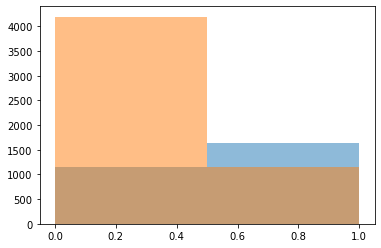

In [260]:
plt.hist(x='proba_material_deprivation', bins=2, data=testing_data[testing_data.material_deprivation == 1].reset_index(), 
         alpha=0.5, density=False)
plt.hist(x='proba_material_deprivation', bins=2, data=testing_data[testing_data.material_deprivation == 0].reset_index(), 
         alpha=0.5, density=False);